In [35]:
import networkx as nx
import random
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

import os

from IPython.display import HTML

from GraphGenusGenerator import GraphGenusGenerator
from HC_Algorithm import hill_climb
from SimulatedAnnealing import simulated_annealing
from RHC_Algorithm import random_hill_climb

from mlrose_hiive.algorithms.decay import GeomDecay
from mlrose_hiive.algorithms.decay import ArithDecay
from mlrose_hiive.algorithms.decay import ExpDecay

In [36]:
seed=random.randint(0, 2**32 - 1)
max_iter = 10000
times_to_run = 1000
number_of_nodes = 10
complete_graph = True
record_file = "TempData.csv"
graph_type = "complete_bipartite" 
# complete, complete_bipartite, billiards 
algorithm_name = "Simulated_Annealing" 
# Random_Hill_Climb, Hill_Climb, Simulated_Annealing
problem = GraphGenusGenerator().generate(seed=seed, number_of_nodes=number_of_nodes, max_connections_per_node=10, graph_type=graph_type)

# Print starting data
print("Starting State:", problem.adj_list)
print("Seed:", seed)
print("Max Iterations:", max_iter)


Starting State: {0: [5, 6, 7, 8, 9], 1: [5, 6, 7, 8, 9], 2: [5, 6, 7, 8, 9], 3: [5, 6, 7, 8, 9], 4: [5, 6, 7, 8, 9], 5: [0, 1, 2, 3, 4], 6: [0, 1, 2, 3, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 3, 4], 9: [0, 1, 2, 3, 4]}
Seed: 2866899760
Max Iterations: 10000


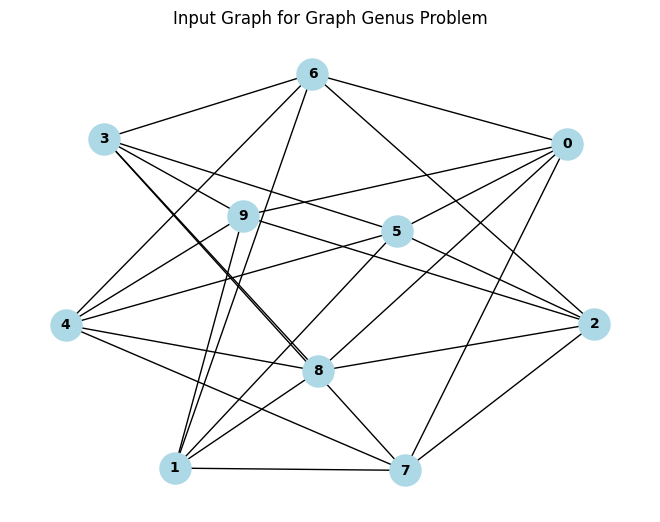

In [37]:
# Get the adjacency list (which is a graph object)
adj_list = problem.adj_list
graph = nx.Graph(adj_list)

def is_power_of_two(n):
    return (n != 0) and (n & (n - 1)) == 0

# Draw the generated graph
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [38]:
# Function to check if a number is a power of two
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0

# Function to get the best result from the CSV file
def get_best_result(file_path):
    df = pd.read_csv(file_path)
    min_fitness = df['Fitness'].min()
    first_min_fitness_index = df[df['Fitness'] == min_fitness].index[0]
    best_result = df.loc[first_min_fitness_index]
    return best_result

# Function to save the best result to a file
def save_best_result(best_result, number_of_nodes, complete_graph, seed, algorithm_name, listed_fitness_over_time, file_path="best_results.csv"):
    data = {
        'Algorithm': [algorithm_name],
        'Number of Nodes': [number_of_nodes],
        'Is Complete': [complete_graph],
        'Final Fitness': [best_result['Fitness']],
        'Plato': [best_result['Iteration']],
        'Time': [best_result['Time']],
        'Seed': [seed],
        'Fitness List': [listed_fitness_over_time],
        'Final State': [best_result['State']]
    }
    df = pd.DataFrame(data)
    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, append the new data
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        # If the file doesn't exist, create a new one
        df.to_csv(file_path, index=False)

# Generate new seeds from the original seed
def generate_seeds(original_seed, count):
    random.seed(original_seed)
    return [random.randint(0, 1000000) for _ in range(count)]

def get_fitness_over_time(filtered_data, target_length=12):
    fitness_values = filtered_data['Fitness'].tolist()
    if len(fitness_values) >= target_length:
        return fitness_values[:target_length]
    else:
        return fitness_values + [fitness_values[-1]] * (target_length - len(fitness_values))

def random_hill_climb_get_fitness_over_time(iteration_data):
    power = 0
    FitnessList = iteration_data['Fitness'][1:]
    iter_length = len(FitnessList)
    best_fit = FitnessList.iloc[0]  # Access the first element

    best_fit_list = []
    for i in range(iter_length):
        current_fitness = FitnessList.iloc[i]  # Access current fitness value
        if current_fitness < best_fit:
            best_fit = current_fitness
        if i == 2**power:
            best_fit_list.append(best_fit)
            power += 1

    return best_fit_list

# Original seed
new_seeds = generate_seeds(seed, times_to_run)
 # Change this as per the algorithm you are using

for i in range(times_to_run):
    record_file = f"{algorithm_name}_iterations.csv"
    new_seed = new_seeds[i]
    print(new_seed)
    
    #set a random state for the problem each run
    problem.random()

    # Run the algorithm
    match algorithm_name:
        case "Simulated_Annealing":
            final_state, final_fitness, iteration_data = simulated_annealing(problem=problem, schedule=GeomDecay(init_temp=10.0, decay=0.99, min_temp=0.001), max_iters=max_iter, max_attempts=50, random_state=seed, curve=True)
        case "Random_Hill_Climb":
            final_state, final_fitness, iteration_data = random_hill_climb(problem=problem, max_iters=max_iter, restarts=10, random_state=seed, record_file=record_file)
        case "Hill_Climb":
            final_fitness, final_state, iteration_data = hill_climb(problem=problem, max_iter=max_iter, seed=seed, record_file=record_file)
        case _:
            print("algorithm_name undefined")
            break  # Break the loop if the algorithm_name is undefined
    
    # Convert the iteration data to a DataFrame and save to CSV
    df_run_stats = pd.DataFrame(iteration_data)
    df_run_stats.to_csv(record_file, index=False)

    if algorithm_name != "Random_Hill_Climb":
        # Filter the data to include only the iterations with iter = to a power of 2 and the last one
        filtered_data = df_run_stats[(df_run_stats['Iteration'] == 0) | 
                             (df_run_stats['Iteration'].apply(is_power_of_two)) | 
                             (df_run_stats['Iteration'] == df_run_stats['Iteration'].max())]
        listed_fitness_over_time = get_fitness_over_time(filtered_data)  
    else:
        listed_fitness_over_time = random_hill_climb_get_fitness_over_time(df_run_stats)

    # Get the best result
    best_result = get_best_result(record_file)
    
    # Save the best result to a summary file
    save_best_result(best_result, number_of_nodes, complete_graph, new_seed, algorithm_name, listed_fitness_over_time, file_path=f"{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv")
    
    # Print final results for each run
    print(f"Run {i+1}/{times_to_run}")
    print(listed_fitness_over_time)
    print("Final Fitness:", final_fitness)
    print("Final State:", final_state)
    print("Plato", best_result['Iteration'])

# Example usage:
# Replace the algorithm_name, number_of_nodes, and complete_graph with actual values.


865948
Run 1/1000
[7.0, 7.0, 7.0, 7.0, 8.0, 7.0, 8.0, 6.0, 7.0, 3.0, 3.0, 3.0]
Final Fitness: 3.0
Final State: {0: [6, 9, 5, 7, 8], 1: [8, 5, 7, 9, 6], 2: [9, 8, 6, 7, 5], 3: [9, 7, 5, 8, 6], 4: [6, 8, 7, 5, 9], 5: [4, 1, 3, 0, 2], 6: [4, 0, 1, 3, 2], 7: [4, 0, 3, 2, 1], 8: [1, 0, 4, 2, 3], 9: [2, 0, 4, 3, 1]}
Plato 323
676384
Run 2/1000
[7.0, 8.0, 7.0, 6.0, 8.0, 6.0, 7.0, 6.0, 7.0, 4.0, 3.0, 3.0]
Final Fitness: 3.0
Final State: {0: [5, 8, 9, 7, 6], 1: [5, 6, 7, 9, 8], 2: [9, 8, 6, 7, 5], 3: [6, 7, 9, 8, 5], 4: [6, 9, 5, 8, 7], 5: [1, 4, 2, 3, 0], 6: [3, 1, 0, 2, 4], 7: [1, 2, 0, 3, 4], 8: [2, 0, 3, 4, 1], 9: [2, 4, 1, 3, 0]}
Plato 641
282236
Run 3/1000
[7.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 7.0, 4.0, 3.0, 3.0]
Final Fitness: 3.0
Final State: {0: [9, 5, 7, 6, 8], 1: [8, 6, 9, 7, 5], 2: [6, 7, 5, 9, 8], 3: [7, 9, 6, 8, 5], 4: [5, 8, 9, 7, 6], 5: [0, 2, 3, 4, 1], 6: [1, 3, 4, 2, 0], 7: [2, 4, 0, 1, 3], 8: [4, 3, 1, 0, 2], 9: [0, 3, 1, 4, 2]}
Plato 945
102896
Run 4/1000
[7.0, 7.0, 7.0, 

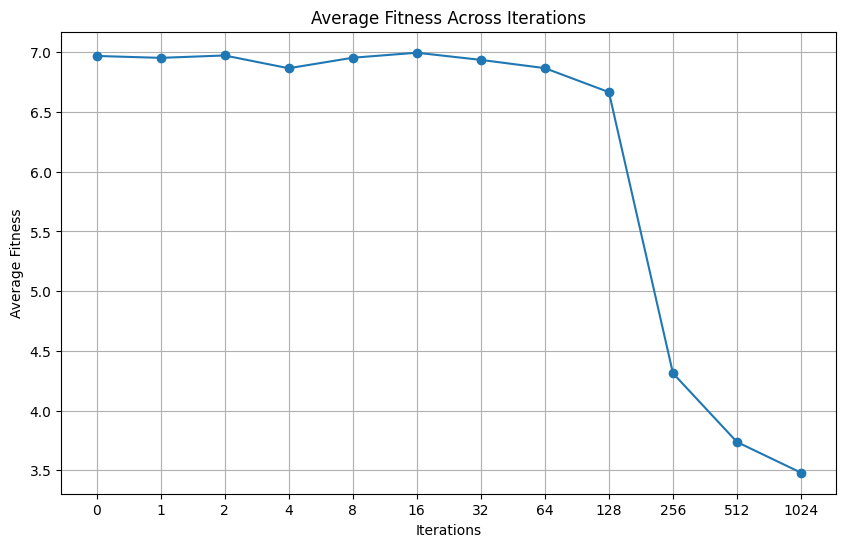

(968.029, 3.395, 3.0, array([6.97 , 6.954, 6.974, 6.867, 6.955, 6.997, 6.937, 6.868, 6.667,
       4.313, 3.737, 3.48 ]))


In [39]:
def average_arrays(array_list):
    """Averages a list of arrays."""
    return np.mean(array_list, axis=0)

def average_plato(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Calculate the average of the "Plato" column
    average_plato_score = df['Plato'].mean()
    average_best_fitness = df['Final Fitness'].mean()
    best_fitness = df['Final Fitness'].min()
    
    # Parse the 'Fitness List' column and ensure each array has length 12
    fitness_over_time_list = df['Fitness List'].apply(ast.literal_eval).apply(lambda x: get_fitness_over_time(pd.DataFrame({'Fitness': x}))).tolist()

    # Calculate the average of the fitness over time if provided
    if fitness_over_time_list:
        average_fitness_over_time = average_arrays(fitness_over_time_list)
    else:
        average_fitness_over_time = None

    pwo2 = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(average_fitness_over_time, marker='o')
    plt.xticks(ticks=range(len(pwo2)), labels=pwo2)
    plt.xlabel('Iterations')
    plt.ylabel('Average Fitness')
    plt.title('Average Fitness Across Iterations')
    plt.grid(True)
    plt.show()

    return average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time


# print(average_plato(f"{algorithm_name}_{graph_type}_5_Best_Results_Summary.csv"))
print(average_plato(f"{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv"))



In [40]:
# import tkinter as tk
# from tkinter import messagebox

# # Function to show a message box
# def show_message_box():
#     root = tk.Tk()
#     root.withdraw()  # Hide the root window
#     messagebox.showinfo("Done", "The test is finished")

# # Display the message box
# show_message_box()


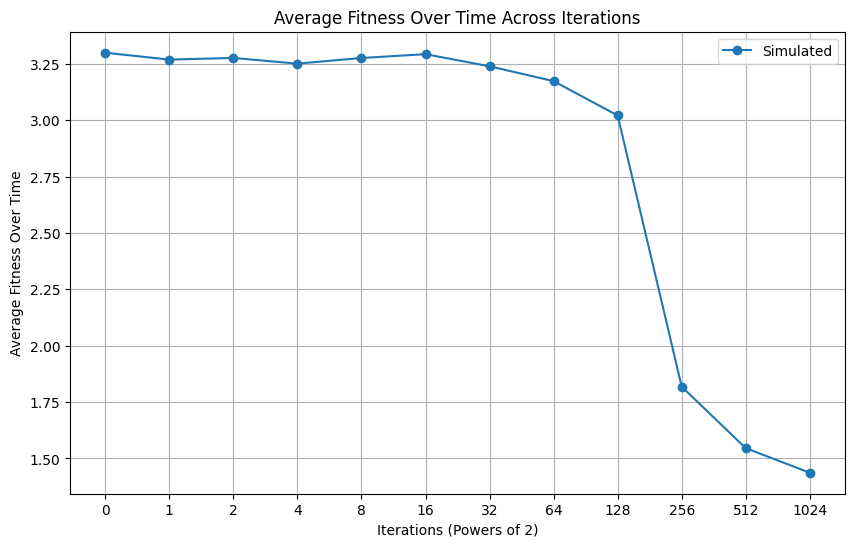

({'Simulated': [3.568, 2.093, 37.151, 640.558, 911.914, 968.029]}, {'Simulated': [0.0, 1.0, 1.0, 1.068, 2.017, 3.395]}, {'Simulated': [0.0, 1.0, 1.0, 1.0, 2.0, 3.0]}, {'Simulated': [array([0.512, 0.506, 0.507, 0.477, 0.458, 0.538, 0.34 , 0.33 , 0.234,
       0.   , 0.   , 0.   ]), array([1.367 , 1.372 , 1.378 , 1.3695, 1.321 , 1.3365, 1.368 , 1.294 ,
       1.134 , 1.    , 1.    , 1.    ]), array([2.276, 2.266, 2.187, 2.234, 2.212, 2.29 , 2.205, 2.184, 1.949,
       1.   , 1.   , 1.   ]), array([3.633, 3.617, 3.626, 3.626, 3.642, 3.613, 3.552, 3.443, 3.384,
       1.771, 1.208, 1.076]), array([5.038, 4.898, 4.985, 4.932, 5.068, 4.983, 5.033, 4.921, 4.758,
       2.825, 2.327, 2.063]), array([6.97 , 6.954, 6.974, 6.867, 6.955, 6.997, 6.937, 6.868, 6.667,
       4.313, 3.737, 3.48 ])]})


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

def average_arrays(array_list):
    """Averages a list of arrays."""
    return np.mean(array_list, axis=0)

def get_fitness_over_time(df):
    """Example function to process fitness over time."""
    return df['Fitness'].to_numpy()

def extrapolate_final_value(fitness_over_time, max_length):
    """Extrapolates the final value of the fitness over time curve to match max_length."""
    if fitness_over_time is not None and len(fitness_over_time) > 0:
        final_value = fitness_over_time[-1]
        # Extend the curve by repeating the last value to match max_length
        extension_length = max_length - len(fitness_over_time)
        if extension_length > 0:
            extended_values = np.repeat(final_value, extension_length)
            return np.concatenate((fitness_over_time, extended_values))
        else:
            return fitness_over_time
    return None

def average_plato(file_paths):
    # Initialize dictionaries to store averaged data
    average_plato_scores = {}
    average_best_fitnesses = {}
    best_fitnesses = {}
    average_fitness_over_times = {}

    # Define powers of 2 for x-axis ticks
    pwo2 = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    max_length = len(pwo2)

    # Process each file path
    for file_path in file_paths:
        # Extract algorithm name from file path
        algorithm_name = file_path.split('_')[0]

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Calculate the average of the "Plato" column
        average_plato_score = df['Plato'].mean()
        average_best_fitness = df['Final Fitness'].mean()
        best_fitness = df['Final Fitness'].min()
        
        # Parse the 'Fitness List' column and ensure each array has length 12
        fitness_over_time_list = df['Fitness List'].apply(ast.literal_eval).apply(lambda x: get_fitness_over_time(pd.DataFrame({'Fitness': x}))).tolist()

        # Calculate the average of the fitness over time if provided
        if fitness_over_time_list:
            average_fitness_over_time = average_arrays(fitness_over_time_list)
            # Extrapolate final value to match max_length
            average_fitness_over_time = extrapolate_final_value(average_fitness_over_time, max_length)
        else:
            average_fitness_over_time = np.repeat(np.nan, max_length)  # Fill with NaN if no data

        # Accumulate data into dictionaries based on algorithm name
        if algorithm_name in average_plato_scores:
            average_plato_scores[algorithm_name].append(average_plato_score)
            average_best_fitnesses[algorithm_name].append(average_best_fitness)
            best_fitnesses[algorithm_name].append(best_fitness)
            average_fitness_over_times[algorithm_name].append(average_fitness_over_time)
        else:
            average_plato_scores[algorithm_name] = [average_plato_score]
            average_best_fitnesses[algorithm_name] = [average_best_fitness]
            best_fitnesses[algorithm_name] = [best_fitness]
            average_fitness_over_times[algorithm_name] = [average_fitness_over_time]

    # Plotting
    plt.figure(figsize=(10, 6))
    for algorithm_name, avg_fitness_list in average_fitness_over_times.items():
        avg_fitness_over_time_avg = average_arrays(avg_fitness_list)
        plt.plot(avg_fitness_over_time_avg, marker='o', label=algorithm_name)
    plt.xticks(ticks=range(len(pwo2)), labels=pwo2)
    plt.xlabel('Iterations')
    plt.ylabel('Average Fitness')
    plt.title('Average Fitness Across Iterations')
    plt.grid(True)
    plt.legend()
    plt.show()

    return average_plato_scores, average_best_fitnesses, best_fitnesses, average_fitness_over_times

# Example usage:
# Replace the list below with your actual file paths
file_paths = [
    "Simulated_Annealing_complete_bipartite_5_Best_Results_Summary.csv",
    "Simulated_Annealing_complete_bipartite_6_Best_Results_Summary.csv",
    "Simulated_Annealing_complete_bipartite_7_Best_Results_Summary.csv",
    "Simulated_Annealing_complete_bipartite_8_Best_Results_Summary.csv",
    "Simulated_Annealing_complete_bipartite_9_Best_Results_Summary.csv",
    "Simulated_Annealing_complete_bipartite_10_Best_Results_Summary.csv",
    # Add more file paths as needed
]

print(average_plato(file_paths))
